# Document Clustering

In this part, we solve a document clustering problem using unsupervised learning algorithms i.e. soft and hard Expectation Maximization for document clustering.

## Task - I: Derivation of Expectation and Maximisation steps of the Hard-EM algorithm

The derivation of the expectation and maximisation steps of the hard-EM algorithm for Document Clustering is mentioned in the PDF report. 

## Task - II: Implementation of the hard-EM and soft-EM algorithms

### Loading Libraries

In [1]:
# installing and loading some packages:
require('tm')
require('SnowballC')
require('ggplot2')

Loading required package: tm
Loading required package: NLP
Loading required package: SnowballC
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



### Auxiliary functions

#### Reading and processing data function

In [2]:
# reading the data
read.data <- function(file.name.txt, sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name.txt)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  
  
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

#### Helper function

In [3]:
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

#### Initialization of model parameters function

In [4]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
} 

#### E-step of the soft-EM and hard-EM for Document Clustering 

In [5]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM and hard-EM

E.step <- function(gamma, model, counts, hard = FALSE){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    # E step:    
    for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    }

    # converting back from the log space 
    gamma <- exp(gamma)
    
    if(hard){
        # finding the cluster with maximum probability for each document
        # replace all the prob values except the maximum probability for each document with 0
        gamma <- t(apply(gamma, 1, function(x) replace(x, x!= max(x), 0))) 
        # replace the maximum probability values for each document with 1
        gamma <- t(apply(gamma, 1, function(x) replace(x, x== max(x), 1)))
    }

    return (gamma) # return calculated posterior probability values
    }

#### M-step of the soft-EM and hard-EM for Document Clustering 

In [6]:
##--- M Step for Document Clustering  --------------------------------------------

M.step <- function(gamma, model, counts){
    # Model Parameter Setting
    eps <- 1e-10 #a small number used to normalize values
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters
    mu_new <- model$mu
    rho_new <- model$rho

    for(i in 1:K){
        rho_new[i,1] <- sum(gamma[,i])/N #calculation of new mixing components
        # calculation of new mu for every word in each cluster
        for(j in 1:W){
            mu_new[i,j] <- sum(gamma[,i] * counts[j,])/sum(gamma[,i] * counts)
        }
        #normalize new mu values
        mu_new[i,] <- (mu_new[i, ] + eps)/ sum(mu_new[i, ] + W*eps)
    }
    
    model_new <- list('rho' = rho_new, 'mu' = mu_new) #storing the values of new parameter
    return (model_new) #returning the new parameter values
}

#### EM algorithm function for Document Clustering

In [7]:
##--- EM for Document Clustering -------------------------------------------
EM <- function(counts, K=4, max.epoch=10, seed=123456, hard=FALSE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts, hard)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

#### Log-likelihood objective

In [8]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

## Task - III: Loading data, run soft-EM and hard-EM algorithms on given data

### Loading data and running soft-EM and hard-EM

In [9]:
### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name.txt='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        

# calling the Soft-EM algorithm on the data
res.Soft <- EM(counts, K=4, max.epoch=5, hard=FALSE)   

## find the culster with the maximum probability (since we have soft assignment here)
label.Soft.hat <- apply(res.Soft$gamma, 1, which.max) 

# calling the Hard-EM algorithm on the data
res.Hard <- EM(counts, K=4, max.epoch=5, hard=TRUE)   

## find the cluster with the maximum probability (since we have soft assignment here)
label.Hard.hat <- apply(res.Hard$gamma, 1, which.max) 

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

[1] 2166395
[1] 1948139
[1] 1933879
[1] 1928413
[1] 1925293
[1] 1922377
[1] 2171036
[1] 1951799
[1] 1934751
[1] 1924865
[1] 1920029
[1] 1918012


## Task - IV: Perform a PCA on the clusterings based on the hard-EM and soft-EM and visualise the obtained clusters with different colors where x and y axes are the first two principal components

### Cluster visualization function

In [10]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

### Visualization for soft-EM

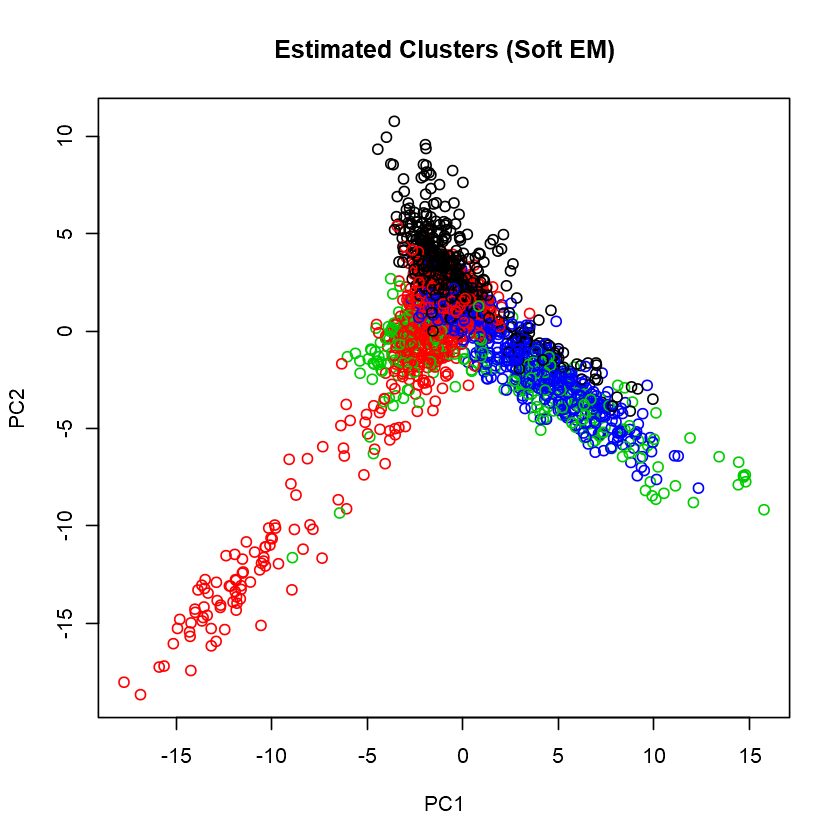

In [11]:
## visualize the stimated clusters for the soft-EM
cluster.viz(t(counts), label.Soft.hat, 'Estimated Clusters (Soft EM)')

### Visualization for Hard-EM

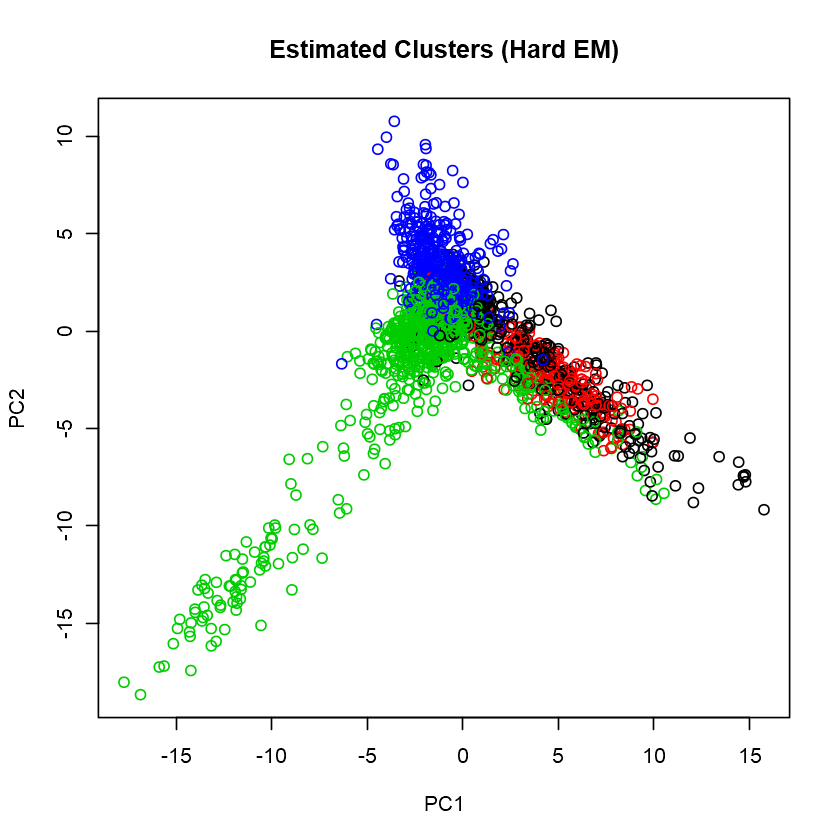

In [12]:
## visualize the stimated clusters for the Hard-EM
cluster.viz(t(counts), label.Hard.hat, 'Estimated Clusters (Hard EM)')

### Visualization of the actual clusters

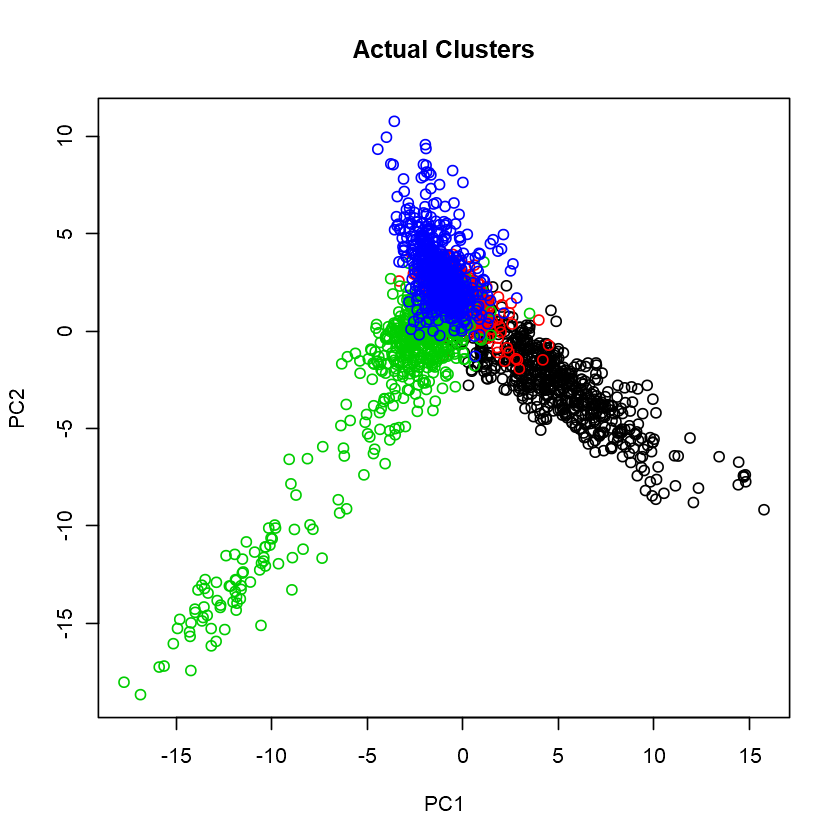

In [13]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Actual Clusters')